# Excitation-Inhibition balance on the artificial matrix

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '95c0ca0cdca3f00e55f0e46dd9a8b8c1f492d94e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences
from connectivity_functions import create_artificial_manager
from plotting_functions import plot_weight_matrix
from analysis_functions import calculate_excitation_inhibition_ratio, get_excitation, get_inhibition

## Example

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 40
n_patterns = 20

dt = 0.001
n = 10


beta = False
value = 1
inhibition = -1.0
extension = 1
decay_factor = 0.3
sequence_decay = 0.0


tau_z_pre = 0.150
g_w = 1.0
g_w_ampa = 1.0
g_a = 97.0

sequences = [[i for i in range(n_patterns)]]


manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)

manager.nn.tau_z_pre = tau_z_pre
manager.nn.g_w = g_w
manager.nn.g_w_ampa = g_w_ampa
manager.nn.g_a = g_a

w = manager.nn.w
ratio, var, ratios = calculate_excitation_inhibition_ratio(manager.nn, sequences)

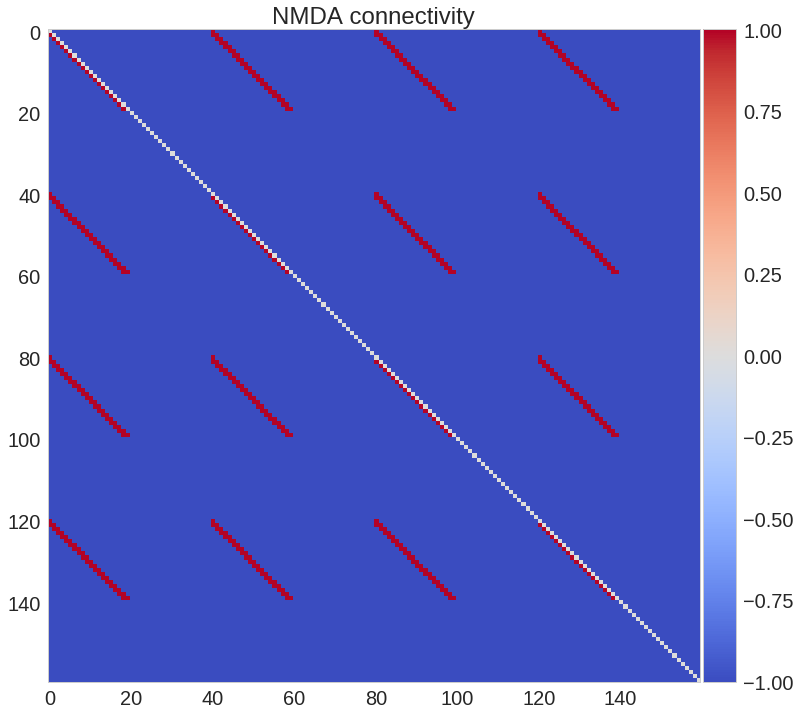

In [5]:
plot_weight_matrix(manager.nn, one_hypercolum=False)

In [6]:
def excitation_artificial_matrix(index, value, hypercolumns):
    if index==0:
        return value * (hypercolumns - 1)
    else:
        return value * hypercolumns + value * (hypercolumns - 1)
    
def inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns):
    if index==0:
        return inhibition * hypercolumns * (minicolumns - 1)
    else:
        return inhibition * hypercolumns * (minicolumns - 2)

In [7]:
index = 1
exc = get_excitation(index, manager.nn.w)
exc_theo = excitation_artificial_matrix(index, value, hypercolumns)
print('total excitation', np.sum(exc))
print('theroetical excitation', exc_theo)

('total excitation', 7.0)
('theroetical excitation', 7)


In [8]:
index = 1
inh = get_inhibition(index, manager.nn.w)
inh_theo = inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns)
print('total inhibition', np.sum(inh))
print('theoretical inhibition', inh_theo)

('total inhibition', -152.0)
('theoretical inhibition', -152.0)


Except for the first element where the inter-sequence nmda conntribution is not present

In [9]:
index = 0
exc = get_excitation(index, manager.nn.w)
exc_theo = excitation_artificial_matrix(index, value, hypercolumns)
inh = get_inhibition(index, manager.nn.w)
inh_theo = inhibition_artificial_matrix(index, inhibition, hypercolumns, minicolumns)

print('total excitation', np.sum(exc))
print('theoretical excitation', exc_theo)

print('total inhibition', np.sum(inh))
print('theoretical inhibition', inh_theo)

('total excitation', 3.0)
('theoretical excitation', 3)
('total inhibition', -156.0)
('theoretical inhibition', -156.0)


Let's build a function for calculating the ratio

In [10]:
def calculate_excitation_inhibition_ratio_artificial(value, inhibition, hypercolumns, minicolumns, n_patterns):
    
    excitation_normal = value * hypercolumns + value * (hypercolumns - 1)
    inhibition_normal = -1 * inhibition * hypercolumns * (minicolumns - 2)
    normal = ((n_patterns - 1.0) / n_patterns) * (excitation_normal / inhibition_normal)
    
    excitation_first = value * (hypercolumns - 1)
    inhibition_first = -1 * inhibition * hypercolumns * (minicolumns - 1)
    first = (1.0 / n_patterns) * (excitation_first / inhibition_first)
    
    return normal + first

In [11]:
ratio, var, ratios = calculate_excitation_inhibition_ratio(manager.nn, sequences)
ratio_theo = calculate_excitation_inhibition_ratio_artificial(value, inhibition,
                                                              hypercolumns, minicolumns, n_patterns)

print('ratio', ratio)
print('ratio theoretical', ratio_theo)

('ratio', 0.044711538461538455)
('ratio theoretical', 0.044711538461538455)


## Ratio dependence on excitation

In [12]:
values = np.arange(0.1, 10, 0.1)
inhibitions = [-3, -1, -0.5]
ratios = []

for inhibition in inhibitions:
    ratio_theo = calculate_excitation_inhibition_ratio_artificial(values, inhibition, hypercolumns, 
                                                                  minicolumns, n_patterns)
    
    ratios.append(ratio_theo)

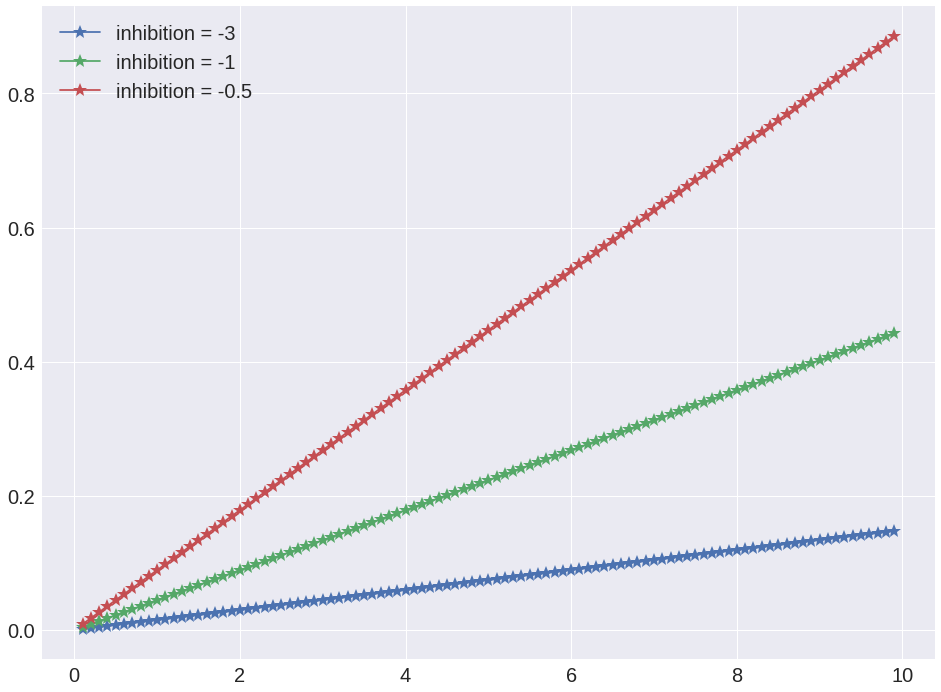

In [13]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for ratio, inhibition in zip(ratios, inhibitions):
    ax.plot(values, ratio, '*-', markersize=14, label='inhibition = ' + str(inhibition))
    
ax.legend();

#### Extension

In [22]:
beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
extensions = [1, 2, 4, 7, 10]

ratios_list = []
for extension in extensions:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

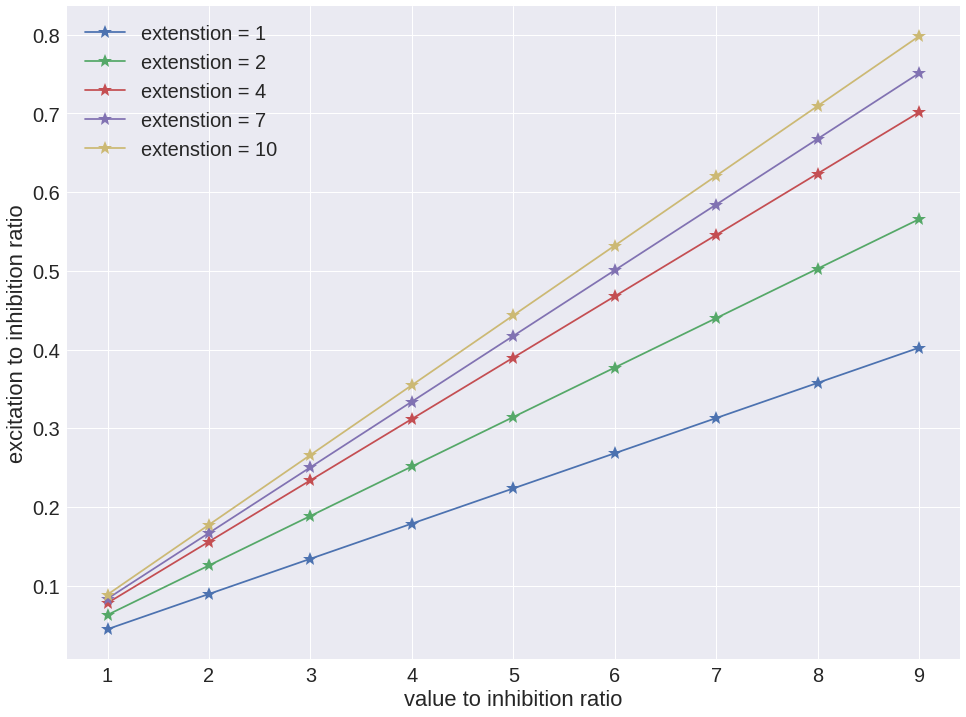

In [23]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, ext in zip(ratios_list, extensions):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='extension = ' + str(ext))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Decay factor

In [29]:
beta = False
value = 1
inhibition = -0.1
extension = 5
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
decay_factors = [0.0, 0.1, 0.3, .6, 0.9]

ratios_list = []
for decay_factor in decay_factors:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

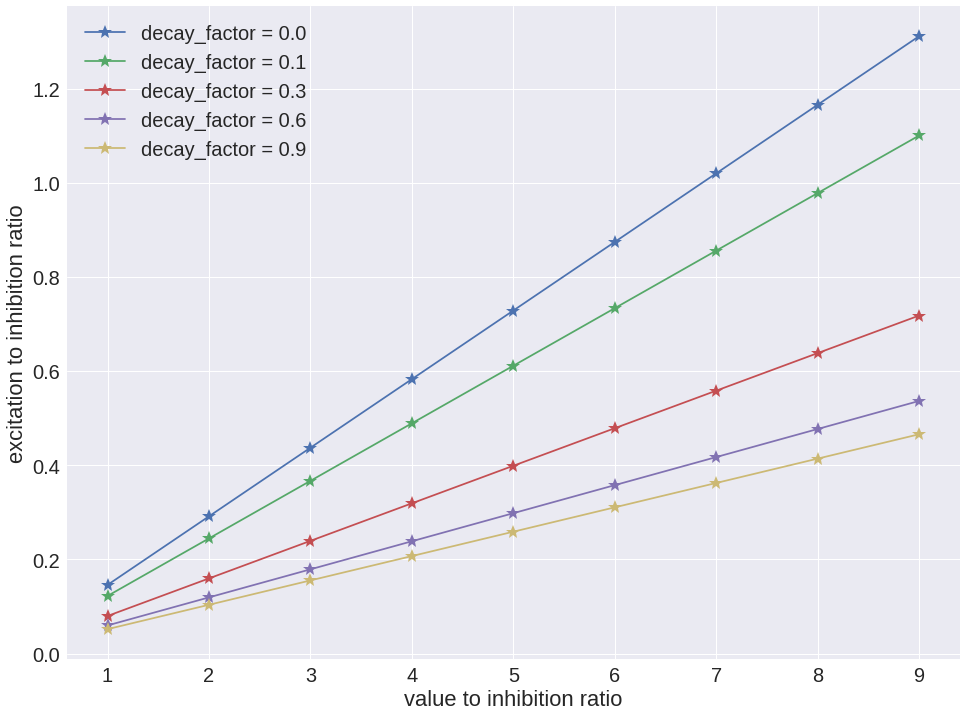

In [30]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, decay_factor in zip(ratios_list, decay_factors):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='decay_factor = ' + str(decay_factor))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Sequence decay

In [31]:
beta = False
value = 1
inhibition = -0.1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0

values = np.arange(0.1, 1, 0.1)
sequence_decays = [0.0, 0.1, 0.3, .6, 0.9]

ratios_list = []
for sequence_decay in sequence_decays:
    ratios = []
    for value in values:
        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value, inhibition=inhibition,
                                        extension=extension, decay_factor=decay_factor, sequence_decay=sequence_decay,
                                        dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True, beta=beta)


        ratio, var, ratios_collect = calculate_excitation_inhibition_ratio(manager.nn, sequences)
        ratios.append(ratio)
    ratios_list.append(ratios)

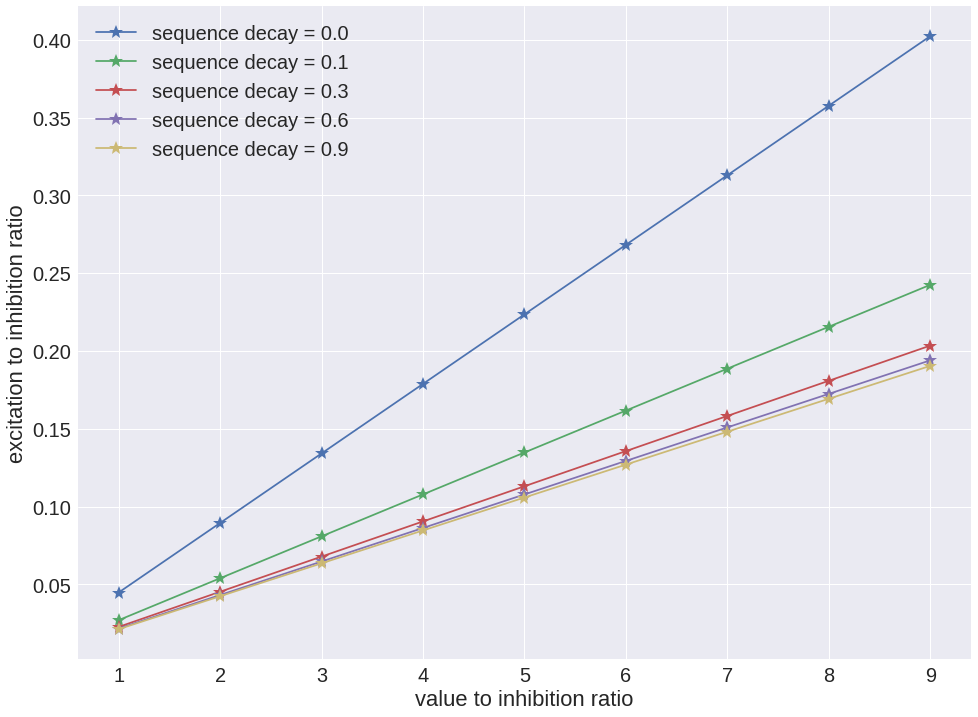

In [34]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

value_to_inhibition = [value / -inhibition for value in values]

for ratios, sequence_decay in zip(ratios_list, sequence_decays):
    ax.plot(value_to_inhibition, ratios, '*-', markersize=14, label='sequence decay = ' + str(sequence_decay))

    
ax.set_xlabel('value to inhibition ratio')
ax.set_ylabel('excitation to inhibition ratio')
ax.legend();

#### Git machinery

In [18]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])